In [292]:
import numpy as np
from significance_of_mean_cuda import significance_of_mean_cuda
from scipy.stats import mannwhitneyu, ttest_ind
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import qvalues, getdf



In [2]:
%load_ext cython
%load_ext rpy2.ipython



R[write to console]: Warning:
R[write to console]:  namespace ‘pbdZMQ’ is not available and has been replaced
by .GlobalEnv when processing object ‘.pbd_env’

/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [3]:
%%R

require(ggplot2)
install.packages("devtools")
library("devtools")
install_github("bdsegal/fastPerm")

library(fastPerm)

R[write to console]: Loading required package: ggplot2

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/devtools_2.2.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 375464 bytes (366 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

In [4]:
np.random.seed(10)

In [5]:
%%R
    runFastPerm <- function(x,y,output, n_samples) {
        e <- list(mode="vector",length=n_samples)
        for (i in 1:n_samples) {
      
            mStopDiffMean(x[[i]], y[[i]])
            valX = fastPerm(x[[i]], y[[i]], testStat = diffMean)
            
            valX <-unlist(valX)

      
            output[[i]] <- as.numeric(valX[1])
      
            }
    

    return(output)


    }

In [6]:
def sns_plot(df, save_name=None):
    #sns.set(font_scale=1.5)
    sns.set(style="white")
    sns.set_context("talk")
    c1, c2 = df.columns
    low = min(min(df[c1]), min(df[c2]))
    hi = max(max(df[c1]), max(df[c2]))
    
    g=sns.lmplot(x=c1, y =c2, data=df, 
                  fit_reg=False, height=7, truncate=True, scatter_kws={"s": 15})
    
    g.set(xscale="log", yscale="log")
    axes = g.axes
    g.set(ylim=(low,hi), xlim=(low,hi))
    plt.plot([low,hi],[low,hi], "k", linewidth=1)
    sns.set_style("ticks")
    sns.despine()
    g.fig.tight_layout()
    if save_name:
        g.savefig(save_name)

In [282]:

    
def exactTest(A,B, bins=10, one_side=True):
    SGM = significance_of_mean_cuda(bins, dtype_v=np.uint32,dtype_A=np.float64, )
    SGM.run(np.asarray(A),np.asarray(B), midP=True)
    if one_side:
        return SGM.get_p_values()
    else:
        return [2 * min( p, (1-p)) for p in SGM.get_p_values()]

def MWU(A, B, one_side=True):
    p_mw = list()
    for a,b in zip(A, B):
        if one_side:
            p_mw.append(mannwhitneyu(a,b, alternative="less")[1])
        else:
            p_mw.append(mannwhitneyu(a,b, alternative="two-sided")[1])
    return p_mw

def ttests(A,B, one_side=True):
    p_t = list()
    for x, y in zip(A, B):
        t, p = ttest_ind(y, x)
        if one_side:
            p = p/2
            if t<0:
                p = 1-p
        p_t.append(p)
    return p_t


In [182]:
def fastPerm(A,B):
    x = pd.DataFrame(A, columns=list(range(A.shape[1]))).T
    y = pd.DataFrame(B, columns=list(range(B.shape[1]))).T
    n_samples = x.shape[1]
    outputDf = pd.DataFrame(n_samples * [0], columns=["output"]).T
    
    %R -i x
    %R -i y
    %R -i outputDf
    %R -i n_samples
    
    
    %R out <- runFastPerm(x,y, outputDf, n_samples)
    
    
    %R -o out
    return list(out.T["output"].values)

In [183]:
class createQvaluePlot:
    def __init__(self, pExactList=None, pMWUList=None, pTtestList=None, pFastPermList=None):
        if isinstance(pExactList, list):
            self.df_e = qvalues(self.getPvalueDf(pExactList), pi0=None)
        else:
            self.df_e = None
        
        if isinstance(pMWUList, list):
            self.df_mw = qvalues(self.getPvalueDf(pMWUList), pi0=None)
        else:
            self.df_mw = None
        
        if isinstance(pTtestList, list):
            self.df_tt = qvalues(self.getPvalueDf(pTtestList), pi0=None)
        else:
            self.df_tt = None
            
        if isinstance(pFastPermList, list):
            self.df_fp = qvalues(self.getPvalueDf(pFastPermList), pi0=None)
        else:
            self.df_fp = None
            
    
    def getPvalueDf(self, pList):
        return pd.DataFrame({"p":np.array(pList).copy()})
    
    def preparePandas(self, q_values, cumulative, test="parallelized shift"):
        preparePd = list()
        for q, cum in zip(q_values, cumulative):
            preparePd.append([q, cum, test])
        return preparePd
    
    def filerByQval(self, df, treshold=0.1):
        return df["q"][df["q"]<treshold]
    
    def getPlotData(self, df, test="parallelized shift"):
        values, base = np.histogram(df, bins=120)
        cumulative = np.cumsum(values)
        data = preparePandas(base[:-1], cumulative, test)
        return data
    
    def createPlot(self):
        D = None
        if isinstance(self.df_e, pd.core.frame.DataFrame):
            data_e = self.getPlotData(self.filerByQval(self.df_e), "parallelized shift")
            if not D:
                D = data_e
            else:
                D += data_e
        
        if isinstance(self.df_mw, pd.core.frame.DataFrame):
            data_mw = self.getPlotData(self.filerByQval(self.df_mw), "MWU")
            if not D:
                D = data_mw
            else:
                D += data_mw

        
        if isinstance(self.df_tt, pd.core.frame.DataFrame):
            data_tt = self.getPlotData(self.filerByQval(self.df_tt), "t test")
            if not D:
                D = data_tt
            else:
                D += data_tt
            
            
        if isinstance(self.df_fp, pd.core.frame.DataFrame):
            data_fp = self.getPlotData(self.filerByQval(self.df_fp), "fastPerm")
            if not D:
                D = data_fp
            else:
                D += data_fp

        if D:
            pdData = pd.DataFrame(D, columns=['%','n', 'Method'])
            self.qPlot(pdData)
    
    def qPlot(self, df):
        a4_dims = (11.7, 8.27)

        fig, ax = plt.subplots(figsize=a4_dims)

        sns.set(style="white")
        sns.set_context("talk")

        snsPlot = sns.lineplot(x="%", y="n",
             hue="Method",
             data=df, ax=ax)

        plt.ylabel(r"$n_{proteins}$",fontsize=20)
        
        
        plt.xlabel(r"$q-value\ (\%)$",fontsize=15)

        sns.set_style("ticks")
        sns.despine()
        plt.tight_layout()
        plt.savefig("figures/experiment/n_proteins")

In [304]:
def getSynteticData(func, setN=20, sampleN=2_000, mean=0, std=1):
    np.random.seed(10)
    AN, BN = [func(mean,std,setN) for i in range(sampleN)], [func(0,std,setN) for i in range(sampleN)]
    return AN, BN

In [325]:
from scipy import stats
def r2(x, y):
    #return stats.pearsonr(x, y)[0] ** 2
    #return mean_squared_error(x,y)
    z=(x-y)/y
    z_abs = np.abs(z)
    
def my_scatter_plot(df):
    sns.set(style="white")
    sns.set_context("talk")
    low = min(df["Theoretical p-value"])
    hi = max(df["Theoretical p-value"])
    f, ax = plt.subplots(figsize=(7, 7))
    #ax.set(xscale="log", yscale="log")
    
    #err2 = r2(df["Observed p-value"], df["Theoretical p-value"])
    
    g=sns.regplot(x='Theoretical p-value', y ='Observed p-value', data=df,  ax=ax, fit_reg=False, 
                  scatter_kws={"s": 5})
    g.plot([low,hi], [low,hi], 'k-', linewidth=.5)
    
    sns.despine()
    #plt.title("Mean relative error : {}".format(np.around(err2,6)))
    f.tight_layout()


In [283]:
def getPrediction(A,B):
    Data = dict()
    
    Data["eList"] = exactTest(B, A, 35, False)
    Data["fpList"] = fastPerm(np.array(A),np.array(B))
    Data["mwuList"] = MWU(A, B, False)
    Data["ttList"] = ttests(A, B, False)
    
    Data["eVttDf"] = pd.DataFrame(data=
                                  {'parallelized': Data["eList"], 'ttest': Data["ttList"] })
    Data["mwuVttDf"] = pd.DataFrame(data={'MWU': Data["mwuList"], 'ttest': Data["ttList"]})
    Data["eVmwuDf"] = pd.DataFrame(data={'parallelized': Data["eList"], 'MWU': Data["mwuList"]})

    Data["eVfpDf"] = pd.DataFrame(data={'parallelized': Data["eList"], 'fastPerm': Data["fpList"]})
    Data["mwuVfpDf"] = pd.DataFrame(data={'MWU': Data["mwuList"], 'fastPerm': Data["fpList"]})
    Data["ttVfpDf"] = pd.DataFrame(data={'ttest': Data["ttList"], 'fastPerm': Data["fpList"]})
                                                      
    return Data

    

    

# $A \sim N(0,1)\ and B \sim N(0,1)$. $ |A|=20$ and $|B|=20$ with $2000$ samples.

In [305]:
AN, BN = getSynteticData(np.random.normal,mean=0,sampleN=8000)
DataNormNoDiff = getPrediction(AN, BN)

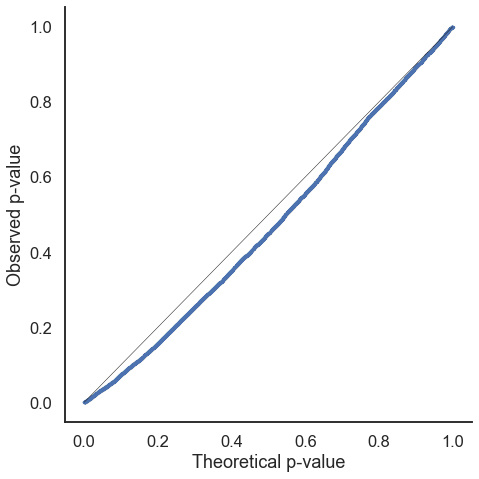

In [326]:
pDfFp = getdf(DataNormNoDiff["fpList"], 8000, "fastPerm")
my_scatter_plot(pDfFp)

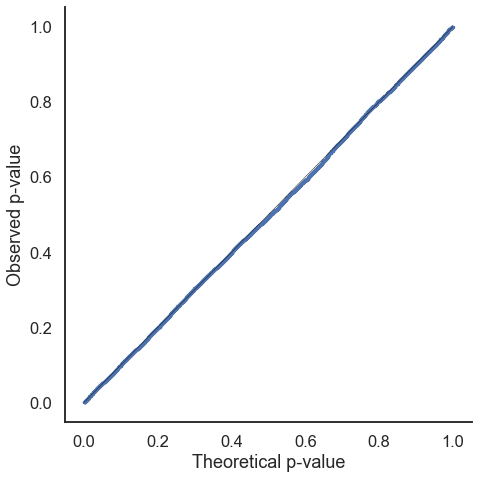

In [327]:
pDfFp = getdf(DataNormNoDiff["ttList"], 8000, "fastPerm")
my_scatter_plot(pDfFp)

In [ ]:
pDfFp = getdf(DataNormNoDiff["eList"], 8000, "fastPerm")
my_scatter_plot(pDfFp)

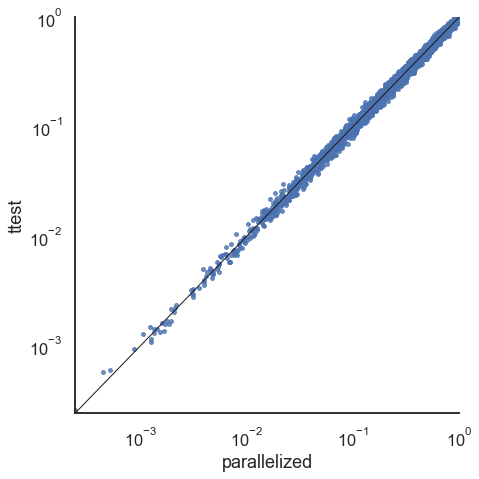

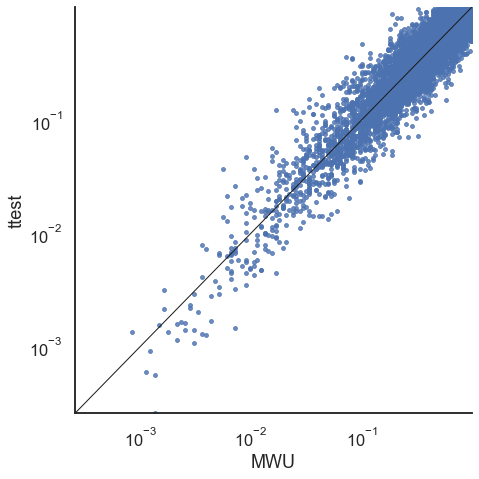

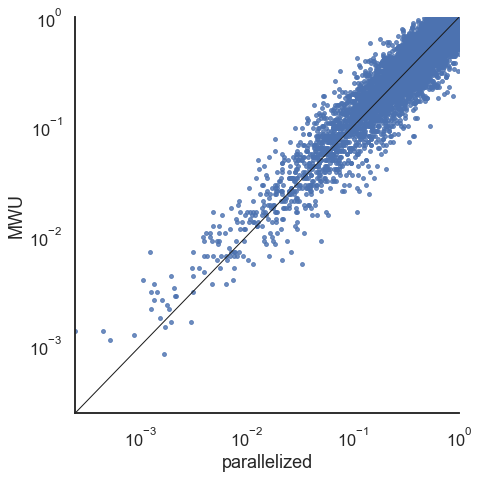

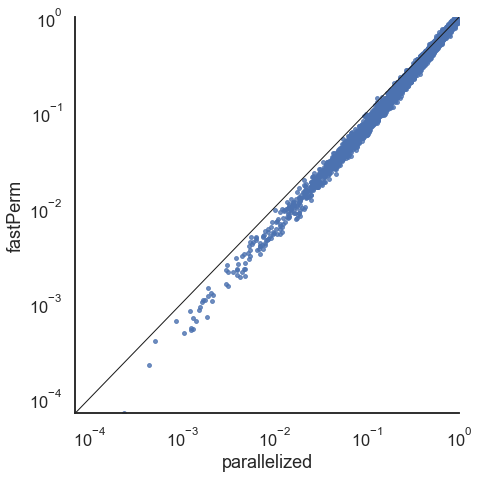

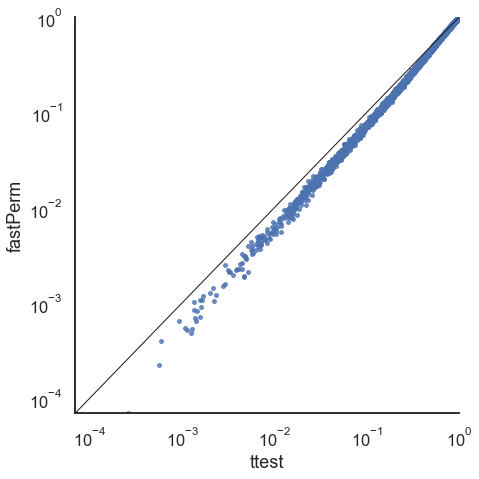

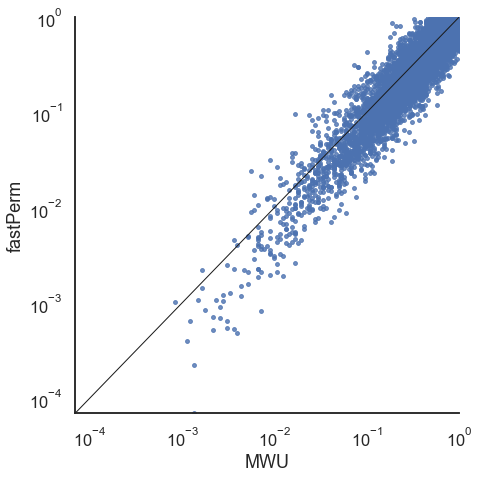

In [315]:
sns_plot(DataNormNoDiff["eVttDf"]) 
sns_plot(DataNormNoDiff["mwuVttDf"])
sns_plot(DataNormNoDiff["eVmwuDf"])
sns_plot(DataNormNoDiff["eVfpDf"])
sns_plot(DataNormNoDiff["ttVfpDf"])
sns_plot(DataNormNoDiff["mwuVfpDf"])

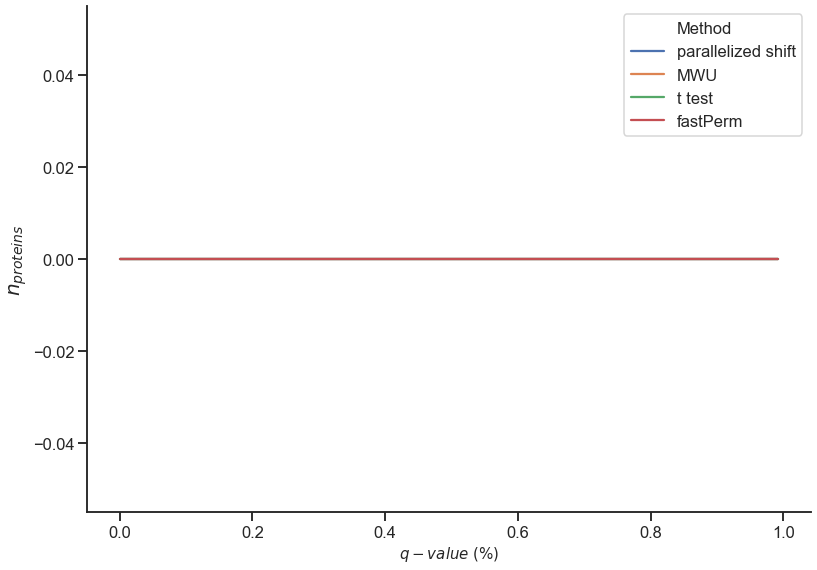

In [316]:

createQvaluePlot(DataNormNoDiff["eList"], 
                 DataNormNoDiff["mwuList"], 
                 DataNormNoDiff["ttList"],
                 DataNormNoDiff["fpList"]
                ).createPlot()



# $A \sim N(0,1)\ and B \sim N(0.5,1)$. $ |A|=20$ and $|B|=20$ with $2000$ samples.

In [317]:
AN, BN = getSynteticData(np.random.normal, mean=0.5, sampleN=8000)
DataNormDiff = getPrediction(AN, BN)

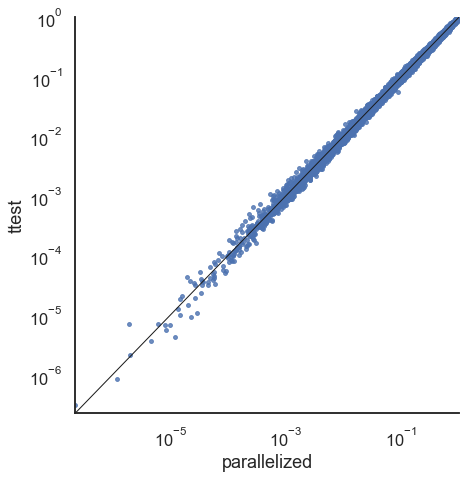

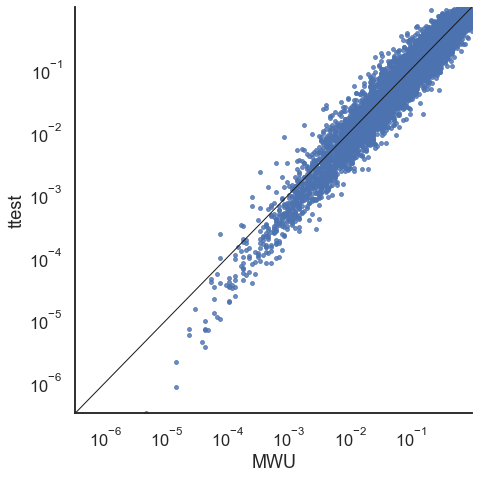

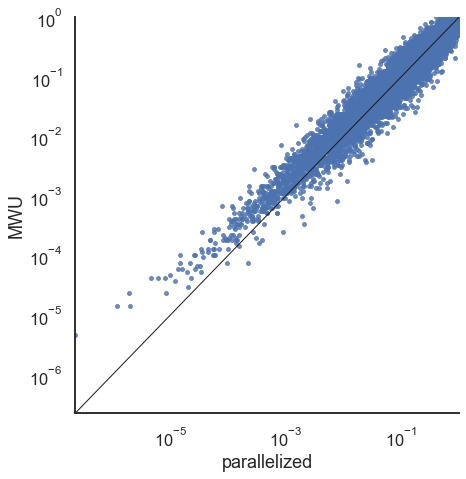

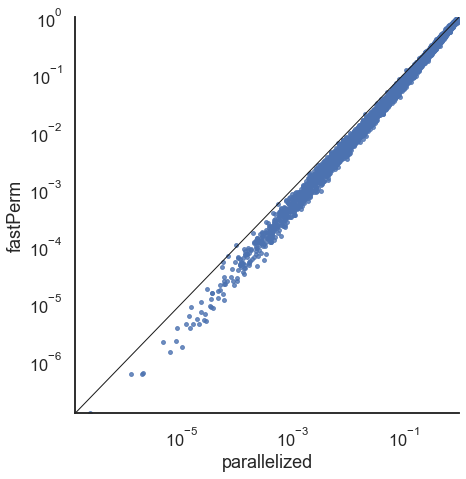

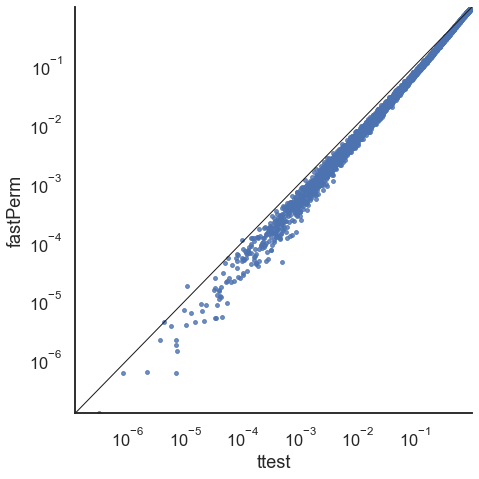

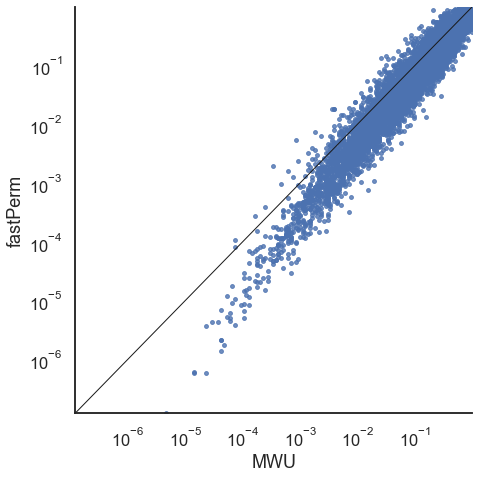

In [318]:
sns_plot(DataNormDiff["eVttDf"]) 
sns_plot(DataNormDiff["mwuVttDf"])
sns_plot(DataNormDiff["eVmwuDf"])
sns_plot(DataNormDiff["eVfpDf"])
sns_plot(DataNormDiff["ttVfpDf"])
sns_plot(DataNormDiff["mwuVfpDf"])

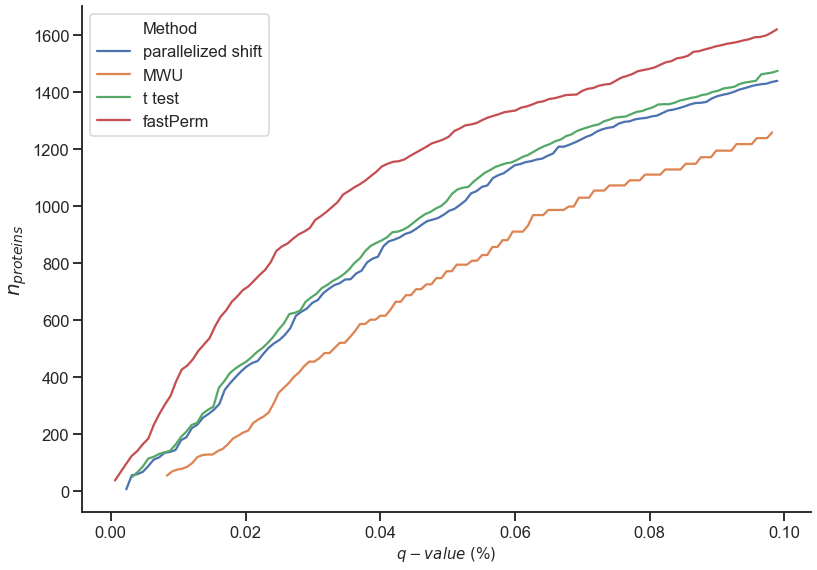

In [191]:
createQvaluePlot(DataNormDiff["eList"], 
                 DataNormDiff["mwuList"], 
                 DataNormDiff["ttList"],
                 DataNormDiff["fpList"]
                ).createPlot()



# $A \sim logN(0,1)\ and B \sim logN(0,1)$. $ |A|=20$ and $|B|=20$ with $2000$ samples.

In [192]:
AN, BN = getSynteticData(np.random.lognormal, mean=0)
DataLogNormNonDiff = getPrediction(AN, BN)

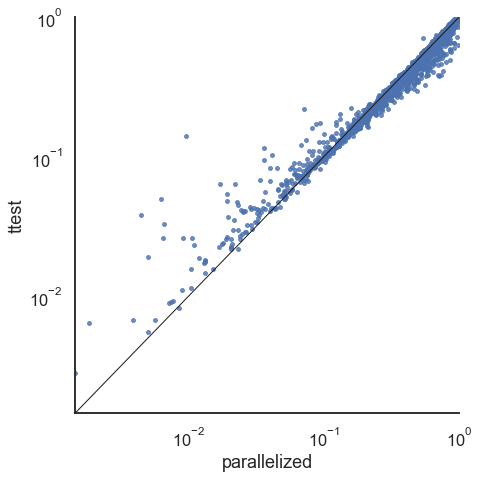

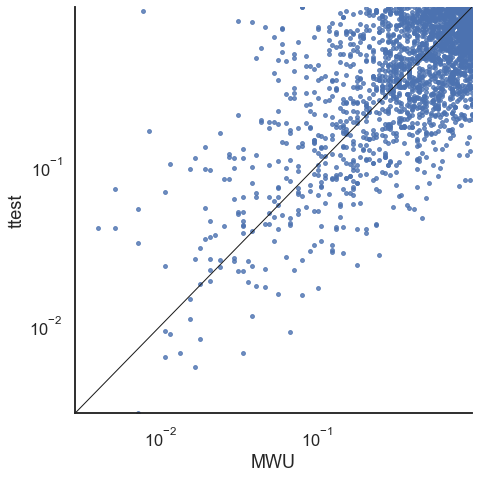

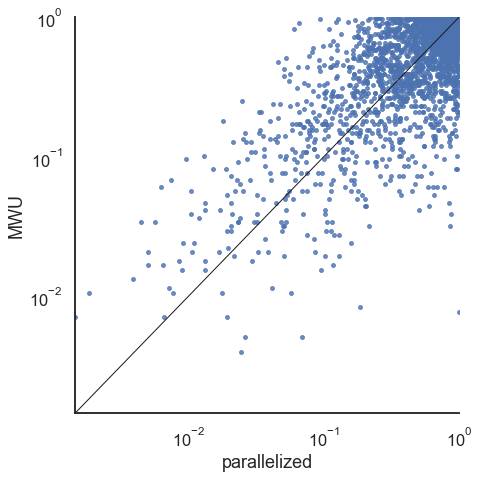

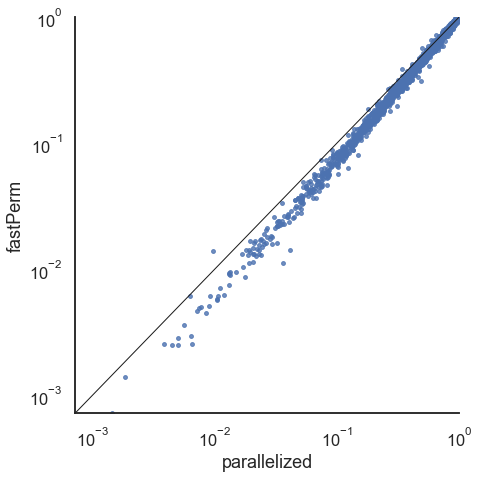

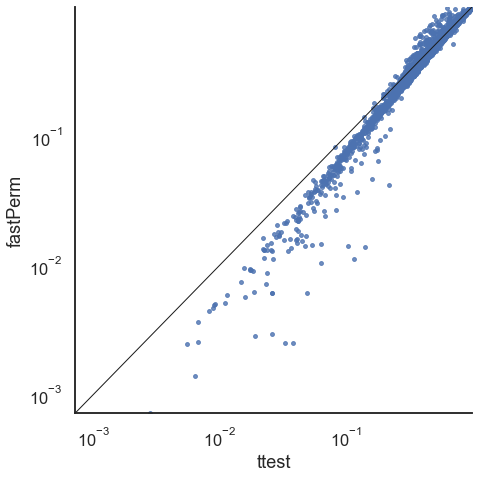

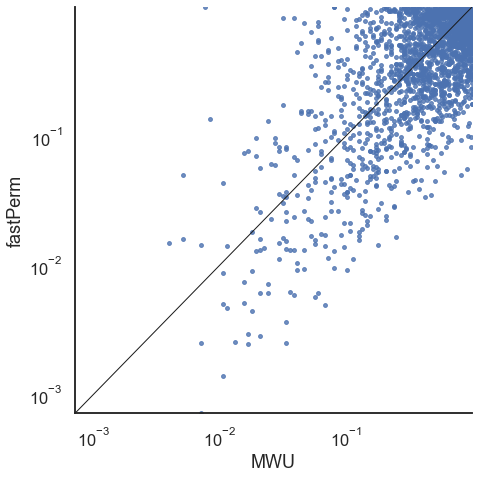

In [200]:
sns_plot(DataLogNormNonDiff["eVttDf"]) 
sns_plot(DataLogNormNonDiff["mwuVttDf"])
sns_plot(DataLogNormNonDiff["eVmwuDf"])
sns_plot(DataLogNormNonDiff["eVfpDf"])
sns_plot(DataLogNormNonDiff["ttVfpDf"])
sns_plot(DataLogNormNonDiff["mwuVfpDf"])

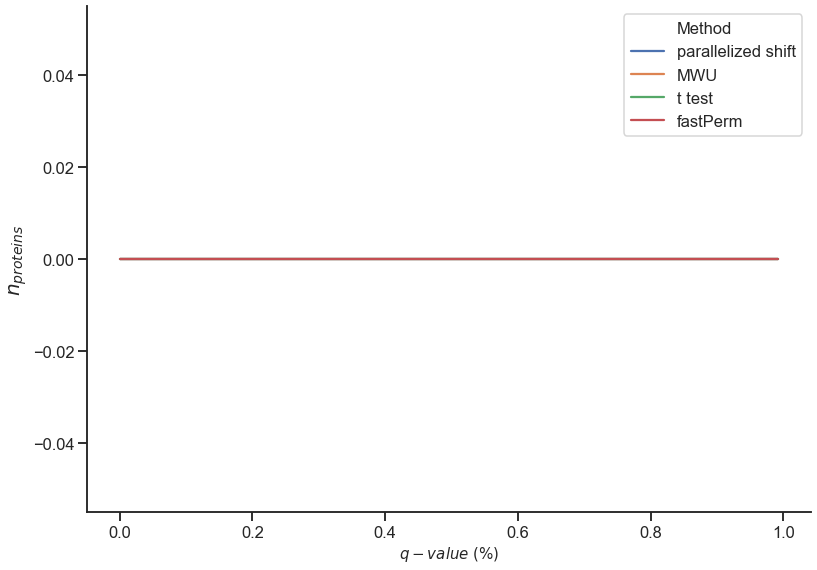

In [194]:
createQvaluePlot(DataLogNormNonDiff["eList"], 
                 DataLogNormNonDiff["mwuList"], 
                 DataLogNormNonDiff["ttList"],
                 DataLogNormNonDiff["fpList"]
                ).createPlot()



# $A \sim logN(0,1)\ and B \sim logN(0.5,1)$. $ |A|=20$ and $|B|=20$ with $2000$ samples.

In [203]:
AN, BN = getSynteticData(np.random.lognormal, mean=0.5)
DataLogNormDiff = getPrediction(AN, BN)

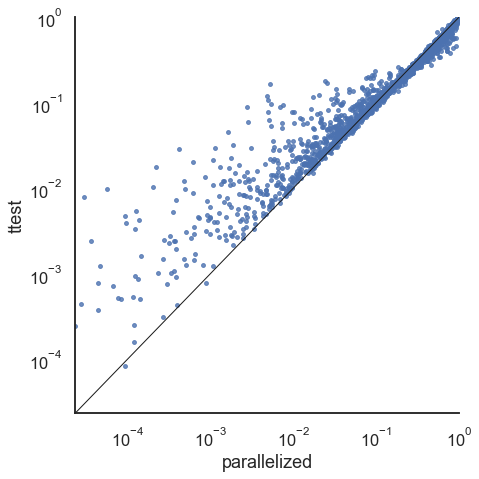

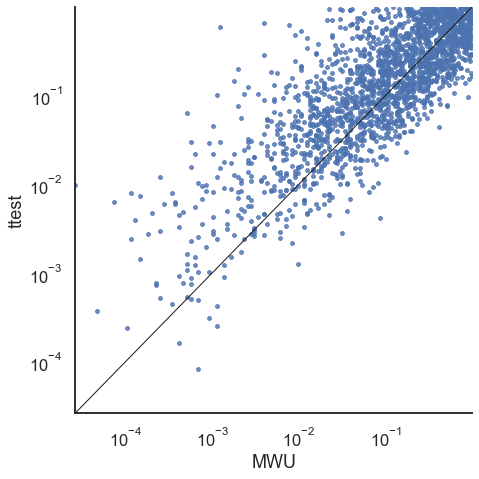

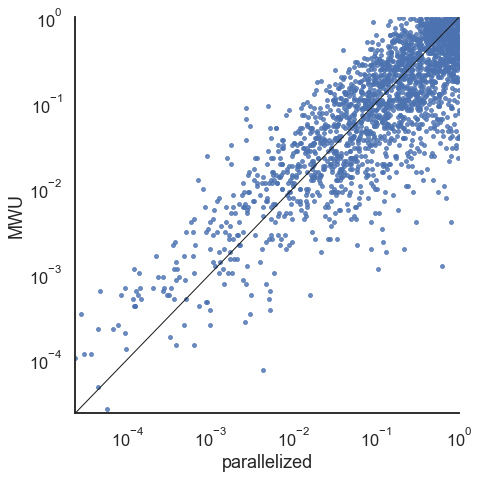

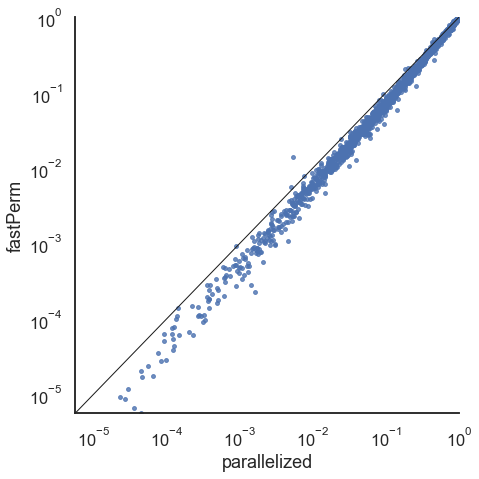

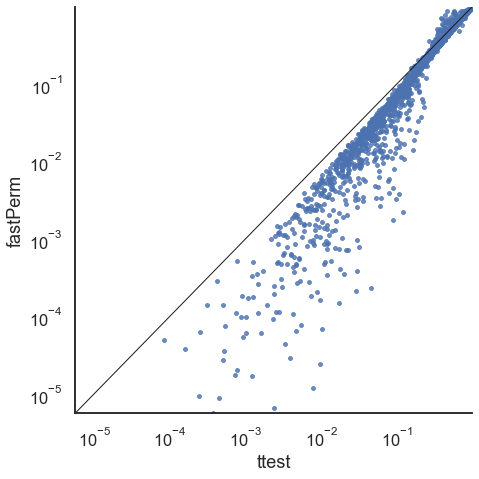

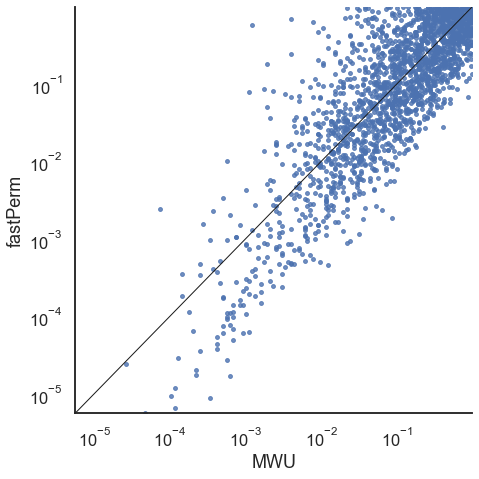

In [204]:
sns_plot(DataLogNormDiff["eVttDf"]) 
sns_plot(DataLogNormDiff["mwuVttDf"])
sns_plot(DataLogNormDiff["eVmwuDf"])
sns_plot(DataLogNormDiff["eVfpDf"])
sns_plot(DataLogNormDiff["ttVfpDf"])
sns_plot(DataLogNormDiff["mwuVfpDf"])

/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


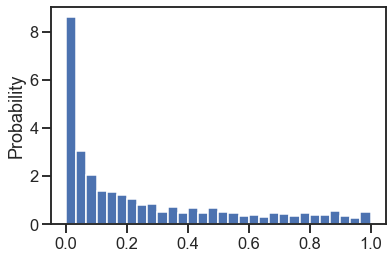

In [321]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#x = np.random.normal(size = 1000)
plt.hist(DataLogNormDiff["fpList"], normed=True, bins=30)
plt.ylabel('Probability');

/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


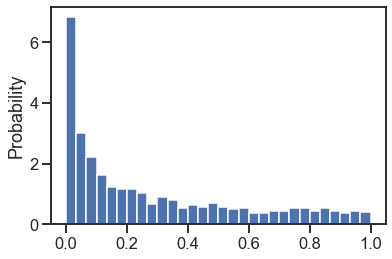

In [322]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#x = np.random.normal(size = 1000)
plt.hist(DataLogNormDiff["eList"], normed=True, bins=30)
plt.ylabel('Probability');

/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


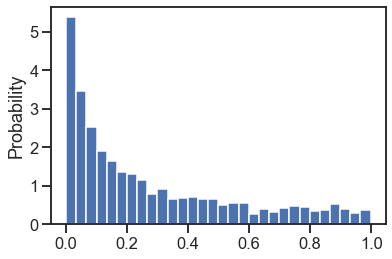

In [323]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#x = np.random.normal(size = 1000)
plt.hist(DataLogNormDiff["ttList"], normed=True, bins=30)
plt.ylabel('Probability');

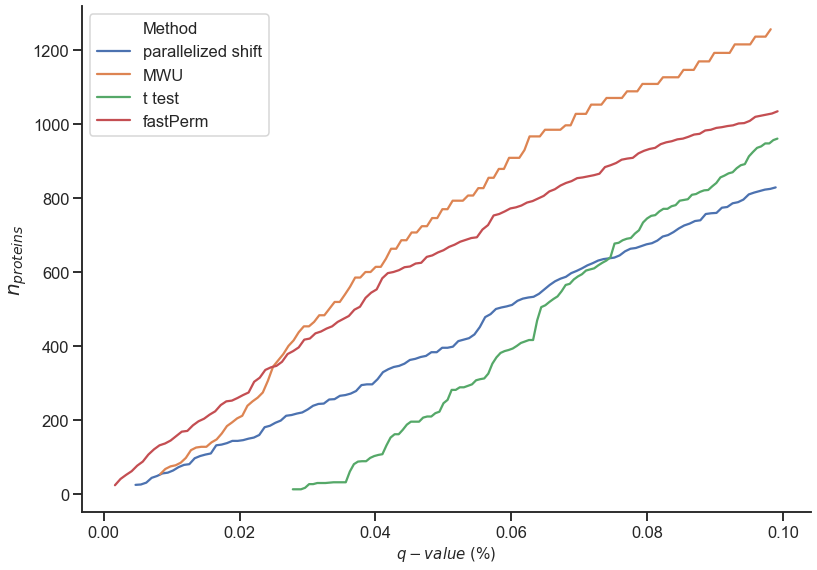

In [205]:
createQvaluePlot(DataLogNormDiff["eList"], 
                 DataLogNormDiff["mwuList"], 
                 DataLogNormDiff["ttList"],
                 DataLogNormDiff["fpList"]
                ).createPlot()


# Experiemntal data: There are 80 patients without triple negative (NTN) and 26 patients with triple negtive (TN), and with a total of 8051 quantified genes.

In [288]:
NotTNP_df = pd.read_csv("data/notTNPdf", index_col=0)
TNP_df = pd.read_csv("data/TNPdf", index_col=0)
NotTNPList = [x for x in NotTNP_df.values]
TNP_dfList = [x for x in TNP_df.values]

In [289]:
DataExperiemnt = getPrediction(NotTNPList, TNP_dfList)

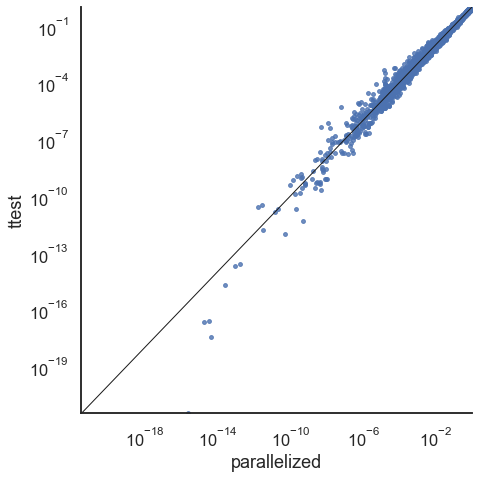

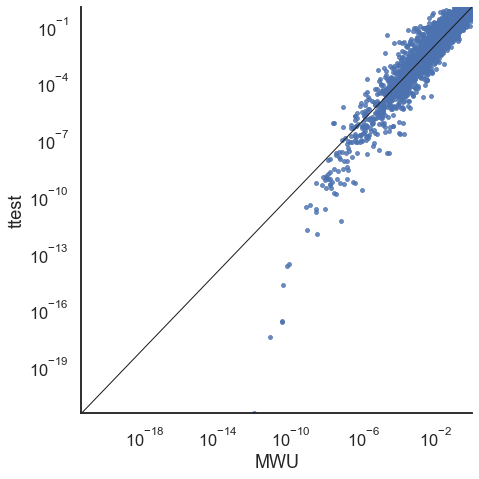

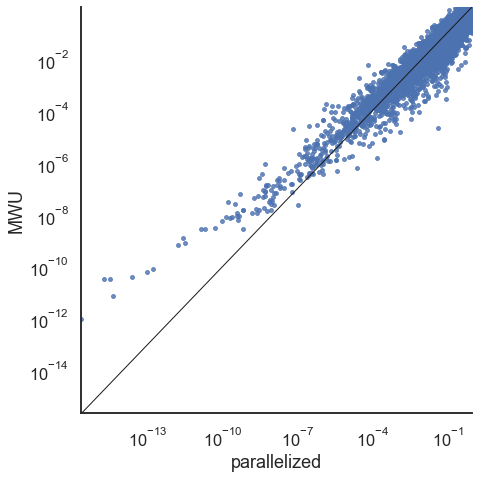

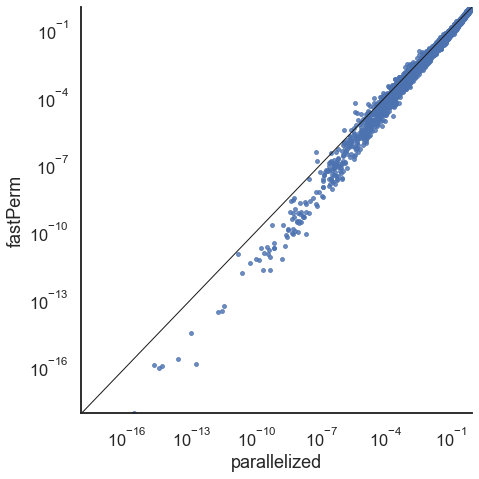

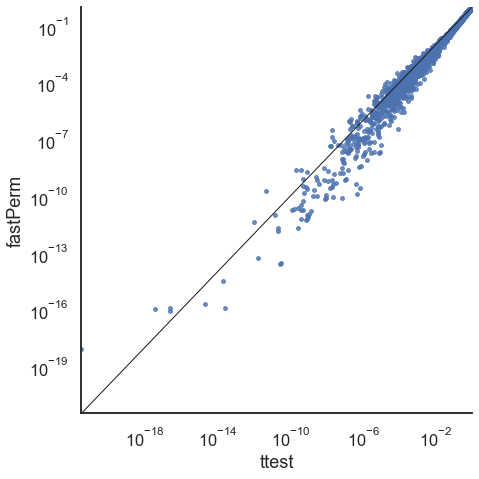

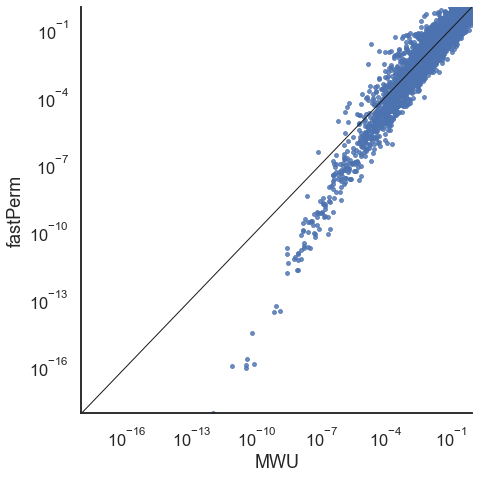

In [290]:
sns_plot(DataExperiemnt["eVttDf"]) 
sns_plot(DataExperiemnt["mwuVttDf"])
sns_plot(DataExperiemnt["eVmwuDf"])
sns_plot(DataExperiemnt["eVfpDf"])
sns_plot(DataExperiemnt["ttVfpDf"])
sns_plot(DataExperiemnt["mwuVfpDf"])

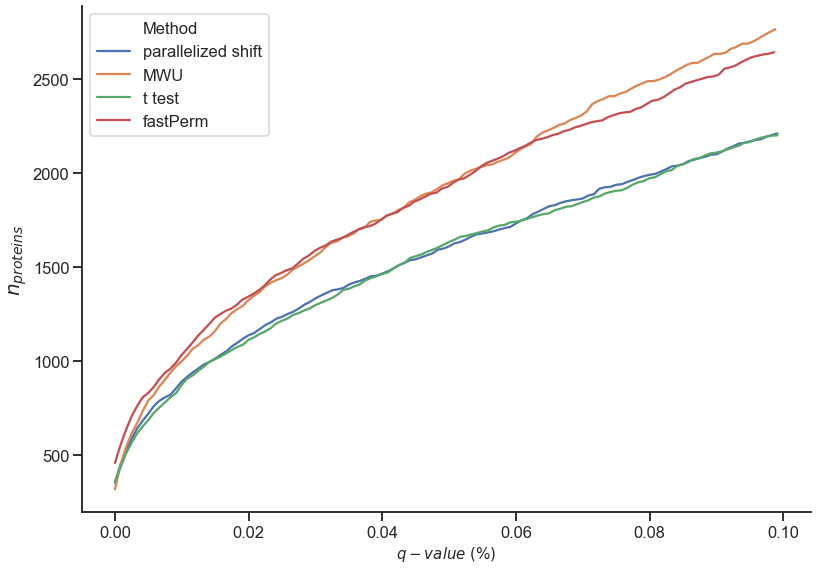

In [291]:
createQvaluePlot(DataExperiemnt["eList"], 
                 DataExperiemnt["mwuList"], 
                 DataExperiemnt["ttList"],
                 DataExperiemnt["fpList"]
                ).createPlot()


In [31]:
pFastPermList = fastPerm(np.array(TNP_dfList),np.array(NotTNPList))
pExactList = exactTest(TNP_dfList, NotTNPList, 30, False)
pMWUList = MWU(NotTNPList, TNP_dfList, False)
pTtestList = ttests(NotTNPList, TNP_dfList, False)

In [32]:
dataExactTtest = pd.DataFrame(data={'parallelized': pExactList, 'ttest': pTtestList})
dataMWUTtest = pd.DataFrame(data={'MWU': pMWUList, 'ttest': pTtestList})
dataEaxactMWU = pd.DataFrame(data={'parallelized': pExactList, 'MWU': pMWUList})

dataExactFastPerm = pd.DataFrame(data={'parallelized': pExactList, 'fastPerm': pFastPermList})
dataMWUFastPerm = pd.DataFrame(data={'MWU': pMWUList, 'fastPerm': pFastPermList})
dataTtestastPerm = pd.DataFrame(data={'ttest': pTtestList, 'fastPerm': pFastPermList})


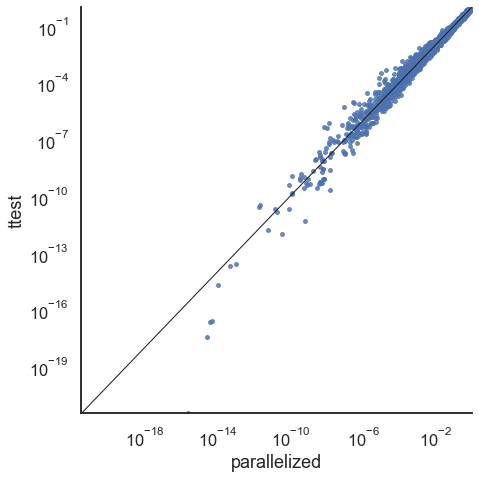

In [33]:
sns_plot(dataExactTtest)

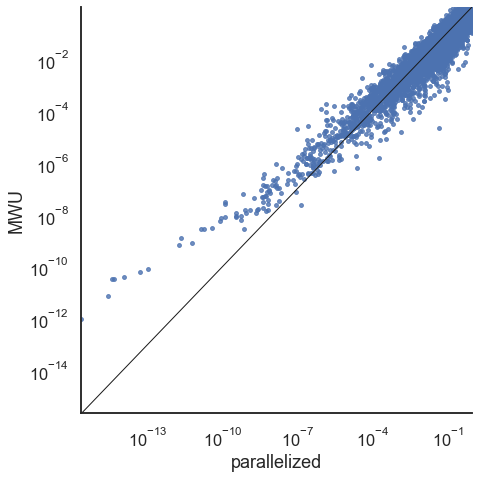

In [34]:
sns_plot(dataEaxactMWU)

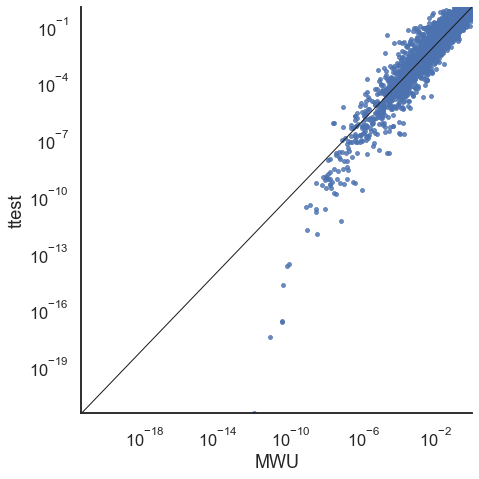

In [35]:
sns_plot(dataMWUTtest)


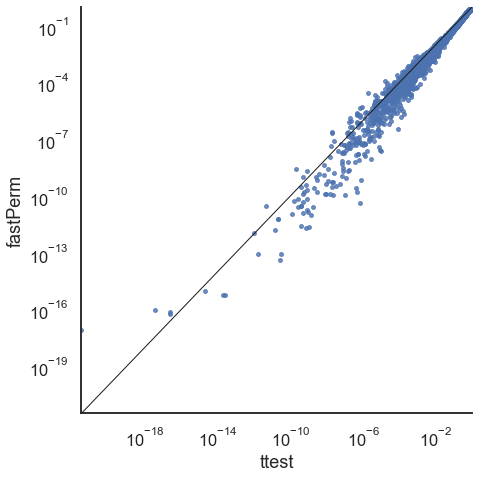

In [36]:
sns_plot(dataTtestastPerm)

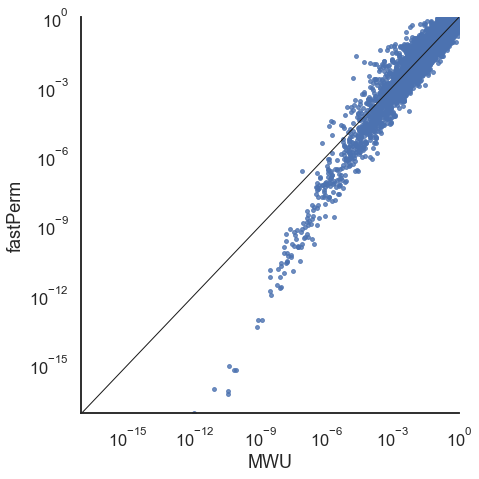

In [37]:
sns_plot(dataMWUFastPerm)

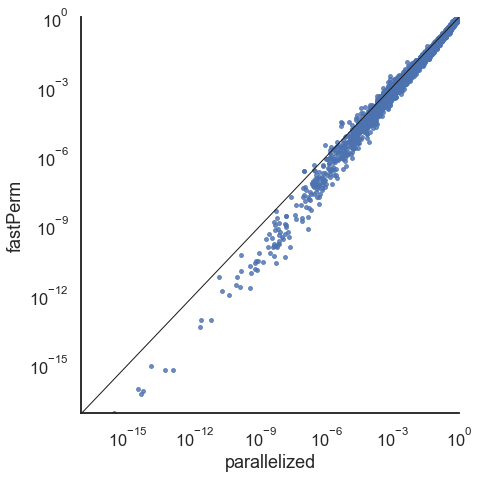

In [127]:
type(dataTtestastPerm)

pandas.core.frame.DataFrame

In [45]:
df_e = pd.DataFrame({"p":np.array(pExactList).copy()})
df_mw = pd.DataFrame({"p":np.array(pMWUList).copy()})
df_tt = pd.DataFrame({"p":np.array(pTtestList).copy()})
df_fp = pd.DataFrame({"p":np.array(pFastPermList).copy() })

df_e = qvalues(df_e, pi0=None)
df_mw = qvalues(df_mw, pi0=None)
df_tt = qvalues(df_tt, pi0=None)
df_fp = qvalues(df_fp, pi0=None)

In [46]:
data_e = df_e["q"][df_e["q"]<0.1]
data_mw = df_mw["q"][df_mw["q"]<0.1]
data_tt = df_tt["q"][df_tt["q"]<0.1]
data_fp = df_fp["q"][df_fp["q"]<0.1]


In [47]:
def preparePandas(q_values, cumulative, test="parallelized shift"):
    preparePd = list()
    for q, cum in zip(q_values, cumulative):
        preparePd.append([q, cum, test])
    return preparePd

In [48]:
values, base = np.histogram(data_e, bins=120)
cumulative = np.cumsum(values)
exactData = preparePandas(base[:-1], cumulative)

values, base = np.histogram(data_mw, bins=120)
cumulative = np.cumsum(values)
mwuData = preparePandas(base[:-1], cumulative, "MWU")

values, base = np.histogram(data_tt, bins=120)
cumulative = np.cumsum(values)
ttData = preparePandas(base[:-1], cumulative, "t test")

values, base = np.histogram(data_fp, bins=120)
cumulative = np.cumsum(values)
fpData = preparePandas(base[:-1], cumulative, "fastPerm")

In [49]:
D = exactData +  mwuData + ttData + fpData
pdData = pd.DataFrame(D, columns=['%','n', 'Method'])

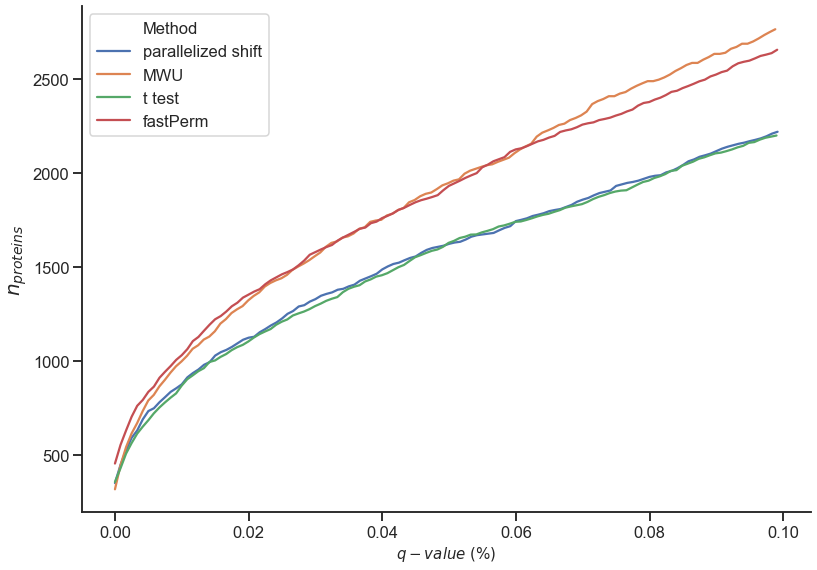

In [50]:
a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)

sns.set(style="white")
sns.set_context("talk")

snsPlot = sns.lineplot(x="%", y="n",
             hue="Method",
             data=pdData, ax=ax)

plt.ylabel(r"$n_{proteins}$",fontsize=20)
        
        
plt.xlabel(r"$q-value\ (\%)$",fontsize=15)

sns.set_style("ticks")
sns.despine()
plt.tight_layout()
plt.savefig("figures/experiment/n_proteins")


In [51]:
np.random.seed(10)
set_n = 20
sample_n = 2_000
AN, BN = [np.random.normal(0.5,1,set_n) for i in range(sample_n)], [np.random.normal(0,1,set_n) for i in range(sample_n)]

In [53]:
pFastPermListNormDiff = fastPerm(np.array(AN),np.array(BN))
pExactListNormDiff = exactTest(BN, AN, 50, False)
pMWUListNormDiff = MWU(AN, BN, False)
pTtestListNormDiff = ttests(AN, BN, False)

In [54]:
dataExactTtestNormDiff = pd.DataFrame(data={'parallelized': pExactListNormDiff, 'ttest': pTtestListNormDiff})
dataMWUTtestNormDiff = pd.DataFrame(data={'MWU': pMWUListNormDiff, 'ttest': pTtestListNormDiff})
dataEaxactMWUNormDiff = pd.DataFrame(data={'parallelized': pExactListNormDiff, 'MWU': pMWUListNormDiff})

dataExactFastPermNormDiff = pd.DataFrame(data={'parallelized': pExactListNormDiff, 'fastPerm': pFastPermListNormDiff})
dataMWUFastPermNormDiff = pd.DataFrame(data={'MWU': pMWUListNormDiff, 'fastPerm': pFastPermListNormDiff})
dataTtestastPermNormDiff = pd.DataFrame(data={'ttest': pTtestListNormDiff, 'fastPerm': pFastPermListNormDiff})


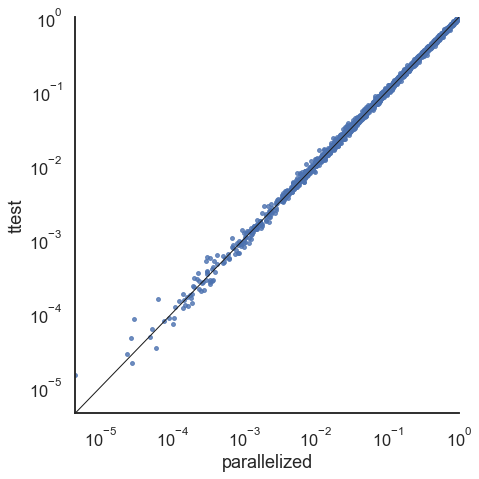

In [55]:
sns_plot(dataExactTtestNormDiff)

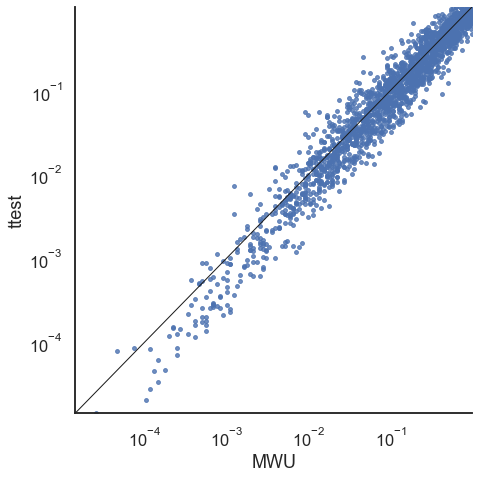

In [56]:
sns_plot(dataMWUTtestNormDiff)

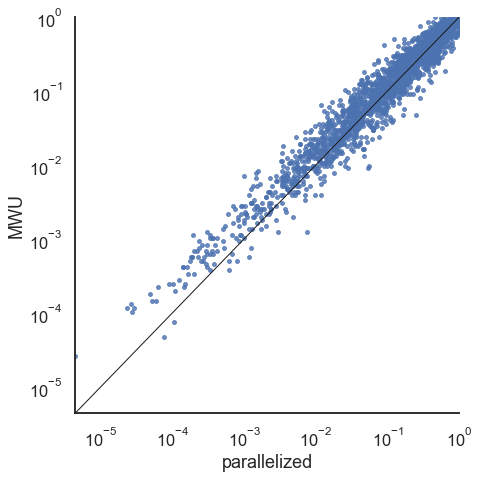

In [57]:
sns_plot(dataEaxactMWUNormDiff)

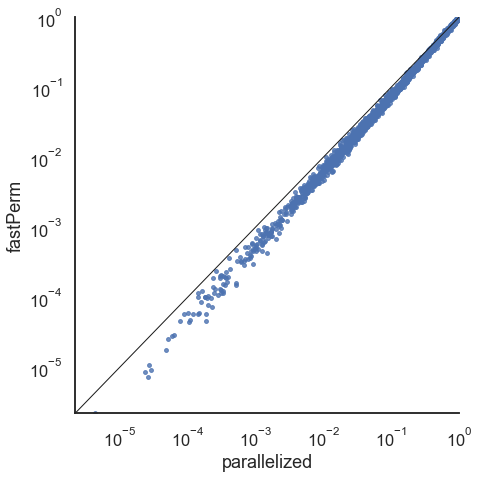

In [58]:
sns_plot(dataExactFastPermNormDiff)

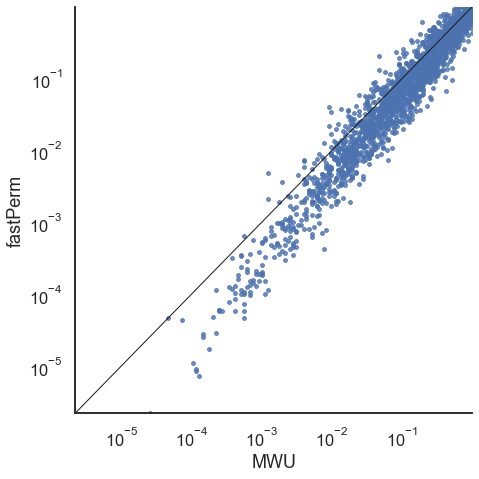

In [59]:
sns_plot(dataMWUFastPermNormDiff)

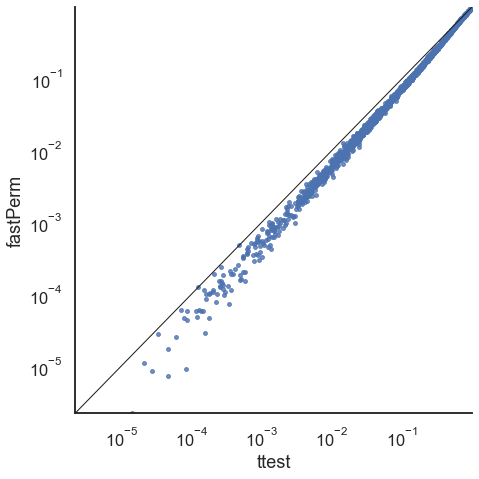

In [60]:
sns_plot(dataTtestastPermNormDiff)

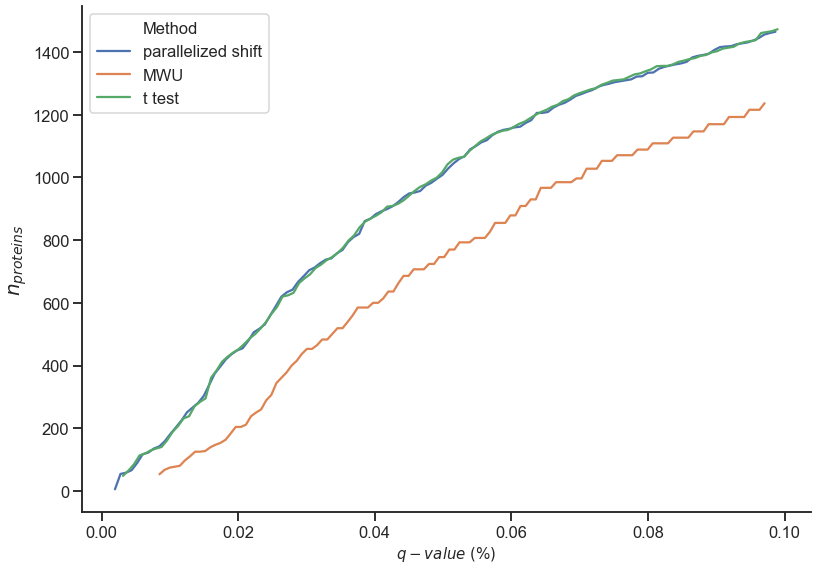

In [135]:
Q = createQvaluePlot(pExactListNormDiff, pMWUListNormDiff, pTtestList, pFastPermListNormDiff).createPlot()
Q.createPlot()

In [75]:
set_n = 20
sample_n = 2_000
AN, BN = [np.random.lognormal(0,2,set_n) for i in range(sample_n)], [np.random.lognormal(0,2,set_n) for i in range(sample_n)]


pFastPermListLogDiff = fastPerm(np.array(AN),np.array(BN))
pExactListLogDiff = exactTest(BN, AN, 50, False)
pMWUListLogDiff = MWU(AN, BN, False)
pTtestListLogDiff = ttests(AN, BN, False)

In [89]:
keep_ix = np.array(pExactListLogDiff) > 10**-10

In [90]:
dataExactTtestLogDiff = pd.DataFrame(data={'parallelized': np.array(pExactListLogDiff)[keep_ix], 'ttest': np.array(pTtestListLogDiff)[keep_ix]})
dataMWUTtestLogDiff = pd.DataFrame(data={'MWU': np.array(pMWUListLogDiff)[keep_ix], 'ttest': np.array(pTtestListLogDiff)[keep_ix]})
dataEaxactMWULogDiff = pd.DataFrame(data={'parallelized': np.array(pExactListLogDiff)[keep_ix], 'MWU': np.array(pMWUListLogDiff)[keep_ix]})

dataExactFastPermLogDiff = pd.DataFrame(data={'parallelized': np.array(pExactListLogDiff)[keep_ix], 'fastPerm': np.array(pFastPermListLogDiff)[keep_ix]})
dataMWUFastPermLogDiff = pd.DataFrame(data={'MWU': np.array(pMWUListLogDiff)[keep_ix], 'fastPerm': np.array(pFastPermListLogDiff)[keep_ix]})
dataTtestastPermLogDiff = pd.DataFrame(data={'ttest': np.array(pTtestListLogDiff)[keep_ix], 'fastPerm': np.array(pFastPermListLogDiff)[keep_ix]})


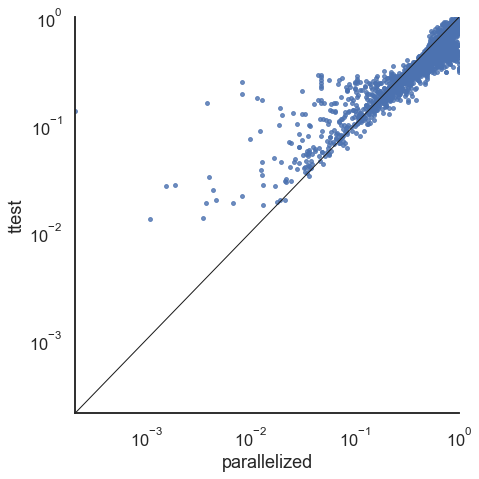

In [95]:
sns_plot(dataExactTtestLogDiff)

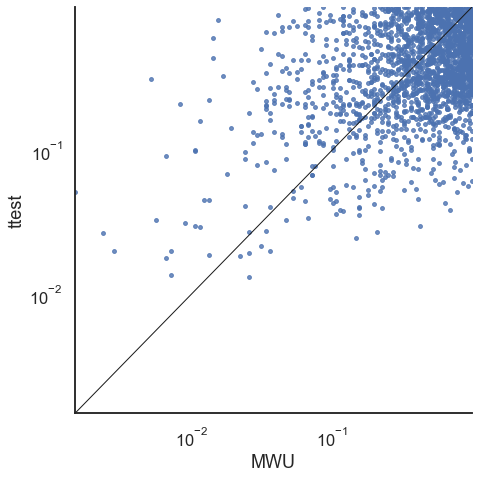

In [140]:
sns_plot(dataMWUTtestLogDiff)

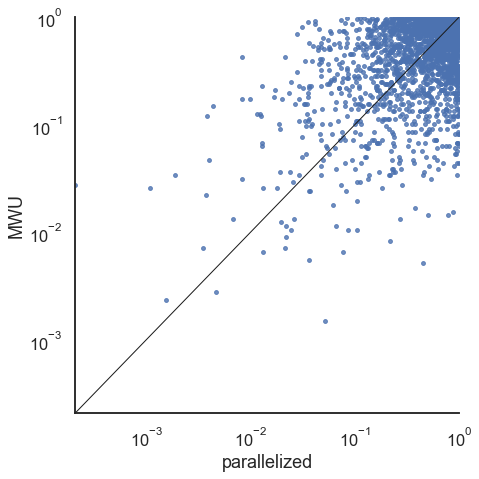

In [97]:
sns_plot(dataEaxactMWULogDiff)

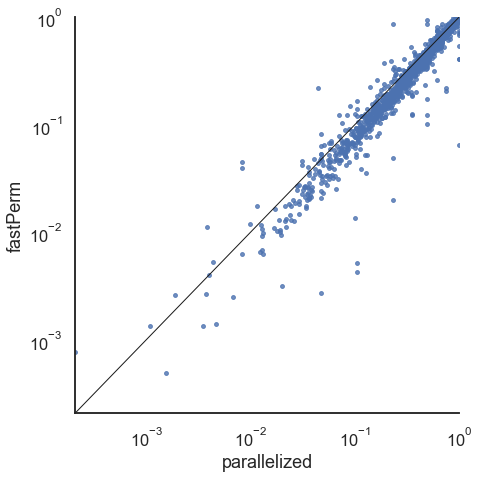

In [98]:
sns_plot(dataExactFastPermLogDiff)

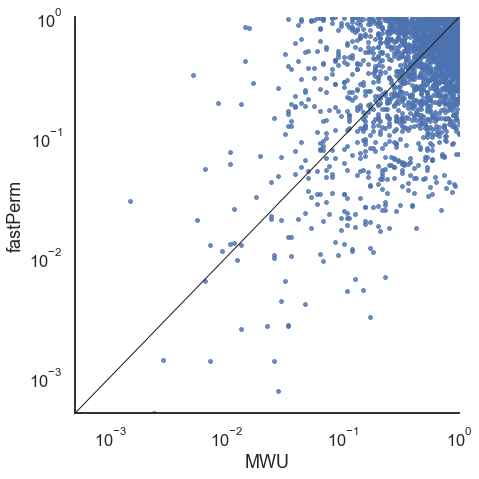

In [99]:
sns_plot(dataMWUFastPermLogDiff)

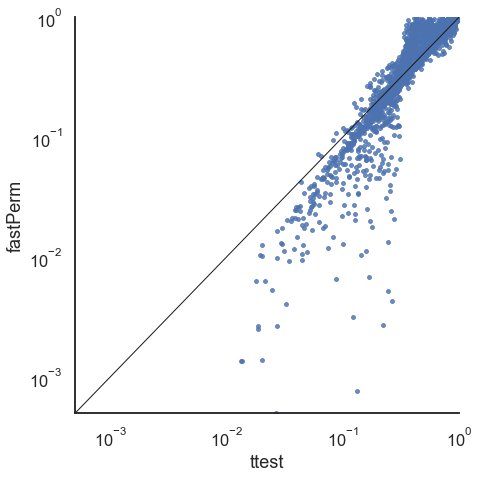

In [100]:
sns_plot(dataTtestastPermLogDiff)

In [105]:
list(np.array(pFastPermListLogDiff)[keep_ix])

[0.375367810390995,
 0.29239826988498,
 0.0211563271586934,
 0.632626438762986,
 0.925225606580846,
 0.166832290778579,
 0.910989199653565,
 0.710088495931161,
 0.716440191562657,
 0.584279773835027,
 0.964781152902707,
 0.584278832350003,
 0.755306492608534,
 0.480222092930956,
 0.869995941141481,
 0.999773256487821,
 0.087705235805291,
 0.858312409397648,
 0.293093292767735,
 0.660840443397442,
 0.428216882686924,
 0.00263931917027042,
 0.593879042930675,
 0.80530195944873,
 0.820836904616918,
 0.0834928579388294,
 0.357613565644731,
 0.851447976154777,
 0.796502618699751,
 0.21885984371007,
 0.978660765470212,
 0.432982991058488,
 0.465361344341512,
 0.827529556786481,
 0.790530751298769,
 0.0651958819655819,
 0.684391755539324,
 0.47899643975734,
 0.274316289178896,
 0.237256302674473,
 0.567768154873305,
 0.701594146119653,
 0.875784042125236,
 0.989433016909468,
 0.0317970999957265,
 0.629814911493166,
 0.334106821012232,
 0.614371435908637,
 0.724762491019168,
 0.643759524894975

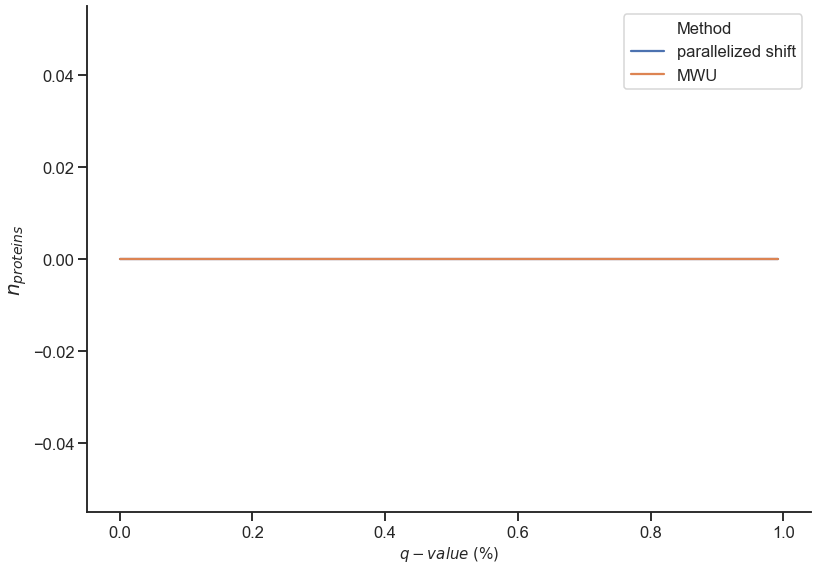

In [138]:
Q = createQvaluePlot(
                     list(np.array(pMWUListLogDiff)[keep_ix]),
                     list(np.array(pTtestListLogDiff)[keep_ix]))
Q.createPlot()